In [14]:
!pip install xgboost
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.7 MB/s eta 0:00:00


In [5]:
from pre_processing import  ChurnDataProcessor


In [7]:
!unzip archive.zip

Archive:  archive.zip
  inflating: customer_churn_telecom_services.csv  


In [60]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    log_loss,
    precision_recall_curve,
    classification_report
)
from scipy.stats import ks_2samp
import optuna
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)


In [17]:
processor = ChurnDataProcessor("customer_churn_telecom_services.csv")

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = processor.run_pipeline()


Iniciando Pipeline de Dados...
Divisão e Balanceamento concluídos.
--- Análise de Outliers (IQR) no Treino ---
Col TotalCharges: 24 outliers encontrados.
Removendo total de 24 registros...


In [70]:
def ks_statistic(y_true, y_prob):
    pos = y_prob[y_true == 1]
    neg = y_prob[y_true == 0]
    ks, _ = ks_2samp(pos, neg)
    return ks

def evaluate_model(model, X_test, y_test, title="Modelo"):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    print(f"\n{title} ")
    print("AUC:", roc_auc_score(y_test, y_prob))
    print("KS:", ks_statistic(y_test, y_prob))
    print("MSE:", mean_squared_error(y_test, y_prob))
    print("Cross-Entropy:", log_loss(y_test, y_prob))

    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.title(f"ROC - {title}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()


def plot_ks_curve(y_true, y_prob, title="Curva KS"):
    data = pd.DataFrame({"y": y_true, "p": y_prob})
    data = data.sort_values("p", ascending=False)

    data["cum_event"] = np.cumsum(data["y"]) / data["y"].sum()
    data["cum_nonevent"] = np.cumsum(1 - data["y"]) / (1 - data["y"]).sum()

    data["ks"] = data["cum_event"] - data["cum_nonevent"]
    ks_value = data["ks"].max()
    ks_idx = data["ks"].idxmax()
    ks_pos = data.index.get_loc(ks_idx)

    plt.figure(figsize=(8,5))
    plt.plot(range(len(data)), data["cum_event"], label="Eventos (Churn)")
    plt.plot(range(len(data)), data["cum_nonevent"], label="Não Eventos")

    plt.vlines(
        ks_pos,
        ymin=data.loc[ks_idx, "cum_nonevent"],
        ymax=data.loc[ks_idx, "cum_event"],
        linestyles="--",
        color="red",
        label=f"KS = {ks_value:.3f}"
    )

    plt.title(f"{title} – KS = {ks_value:.3f}")
    plt.xlabel("Amostras ordenadas por probabilidade")
    plt.ylabel("Taxa acumulada")
    plt.legend()
    plt.grid()
    plt.show()

    return ks_value




=== Baseline XGBoost ===
AUC: 0.8501790507332474
KS: 0.5458498952503567
MSE: 0.14922596514225006
Cross-Entropy: 0.45014671370233533

Matriz de Confusão:
[[1006  288]
 [ 122  345]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1294
           1       0.55      0.74      0.63       467

    accuracy                           0.77      1761
   macro avg       0.72      0.76      0.73      1761
weighted avg       0.80      0.77      0.78      1761



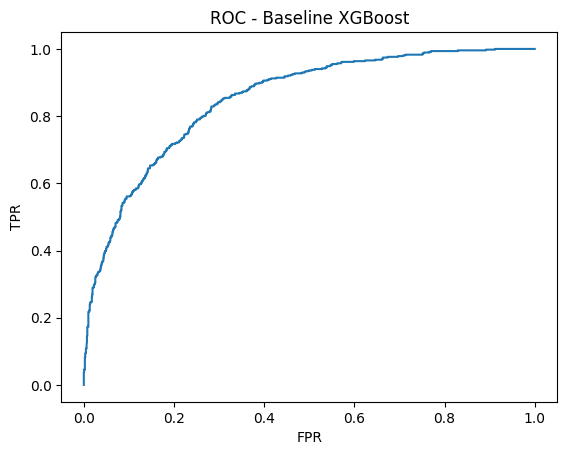

In [28]:
#@title Baseline
baseline = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    eval_metric="logloss"
)

baseline.fit(X_train, y_train)
baseline_results = evaluate_model(baseline, X_test, y_test, "Baseline XGBoost")


In [ ]:
#@title Experimento 1

[I 2025-12-01 01:45:29,509] A new study created in memory with name: no-name-352b2d5f-14a0-45f8-a925-a739decae9f3
[I 2025-12-01 01:45:36,263] Trial 0 finished with value: 0.8119052617790243 and parameters: {'n_estimators': 2947, 'learning_rate': 0.057641355734360765, 'max_depth': 3, 'subsample': 0.8727276656215686, 'colsample_bytree': 0.9874769026341095, 'min_child_weight': 4}. Best is trial 0 with value: 0.8119052617790243.
[I 2025-12-01 01:45:37,694] Trial 1 finished with value: 0.8294155153964264 and parameters: {'n_estimators': 1580, 'learning_rate': 0.04401485053581024, 'max_depth': 3, 'subsample': 0.8359236430299823, 'colsample_bytree': 0.8573403416207034, 'min_child_weight': 12}. Best is trial 1 with value: 0.8294155153964264.
[I 2025-12-01 01:45:38,950] Trial 2 finished with value: 0.8204338430085493 and parameters: {'n_estimators': 1396, 'learning_rate': 0.09352843821965362, 'max_depth': 3, 'subsample': 0.9019260059733687, 'colsample_bytree': 0.7335697154746867, 'min_child_wei

Melhores parâmetros EXP1: {'n_estimators': 262, 'learning_rate': 0.013095854969045907, 'max_depth': 4, 'subsample': 0.7151374555268708, 'colsample_bytree': 0.928965526714285, 'min_child_weight': 9}

=== Experimento 1 ===
AUC: 0.8657475285372449
KS: 0.577149022502143
MSE: 0.15048208832740784
Cross-Entropy: 0.4555663871603677

Matriz de Confusão:
[[954 340]
 [ 84 383]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1294
           1       0.53      0.82      0.64       467

    accuracy                           0.76      1761
   macro avg       0.72      0.78      0.73      1761
weighted avg       0.82      0.76      0.77      1761



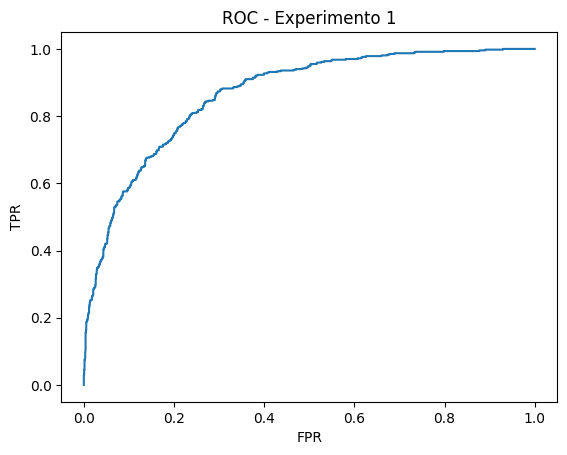

In [52]:
# ================================================
# CÉLULA 4 — EXPERIMENTO 1 (LR + Estimators)
# ================================================

def objective_exp1(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "random_state": SEED,
        "min_child_weight": trial.suggest_int("min_child_weight",1, 12),
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val, y_proba)

study1 = optuna.create_study(direction="maximize")
study1.optimize(objective_exp1, n_trials=100)

best1 = study1.best_params
print("Melhores parâmetros EXP1:", best1)

model1 = XGBClassifier(**best1, random_state=SEED, eval_metric="logloss")
model1.fit(X_train, y_train)
exp1_results = evaluate_model(model1, X_test, y_test, "Experimento 1")


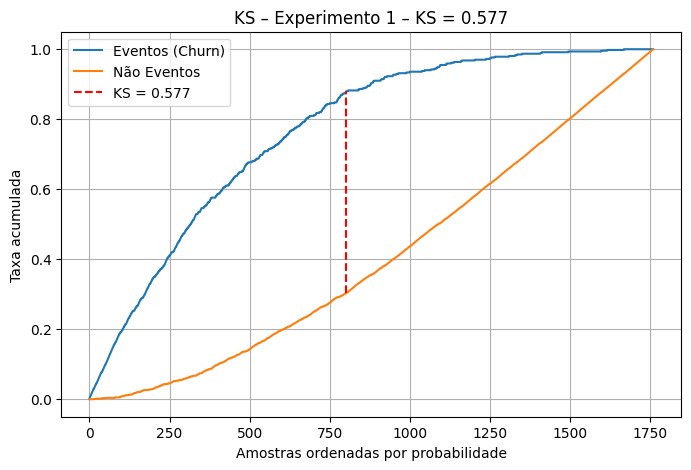

0.577149022502143

In [71]:
y_prob_exp2 = model1.predict_proba(X_test)[:, 1]
plot_ks_curve(y_test, y_prob_exp2, title="KS – Experimento 1")

In [ ]:
#@title Experimento 2

[I 2025-12-01 03:18:00,853] A new study created in memory with name: no-name-e4913a88-62da-4da9-ad96-8d55d509467d
[I 2025-12-01 03:18:02,397] Trial 0 finished with value: 0.8407209622400109 and parameters: {'gamma': 7.102724063307848, 'reg_alpha': 3.1406573960385598, 'reg_lambda': 19.58879005653872, 'scale_pos_weight': 6.865427022537429}. Best is trial 0 with value: 0.8407209622400109.
[I 2025-12-01 03:18:03,673] Trial 1 finished with value: 0.843046830186219 and parameters: {'gamma': 6.772030775676932, 'reg_alpha': 2.046748114569843, 'reg_lambda': 2.5314904809726, 'scale_pos_weight': 3.300352574346842}. Best is trial 1 with value: 0.843046830186219.
[I 2025-12-01 03:18:05,322] Trial 2 finished with value: 0.8407888511462459 and parameters: {'gamma': 0.7673573033717995, 'reg_alpha': 5.677638898872523, 'reg_lambda': 13.208283127408274, 'scale_pos_weight': 6.98233135633919}. Best is trial 1 with value: 0.843046830186219.
[I 2025-12-01 03:18:06,314] Trial 3 finished with value: 0.84054122

Melhores parâmetros EXP2: {'gamma': 6.532472975431998, 'reg_alpha': 1.0682088192148673, 'reg_lambda': 15.729550894972714, 'scale_pos_weight': 1.1931865084670281}

Experimento 2 
AUC: 0.8660958666088585
KS: 0.5741538115300729
MSE: 0.16271217167377472
Cross-Entropy: 0.48942069294887625

Matriz de Confusão:
[[922 372]
 [ 67 400]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1294
           1       0.52      0.86      0.65       467

    accuracy                           0.75      1761
   macro avg       0.73      0.78      0.73      1761
weighted avg       0.82      0.75      0.76      1761



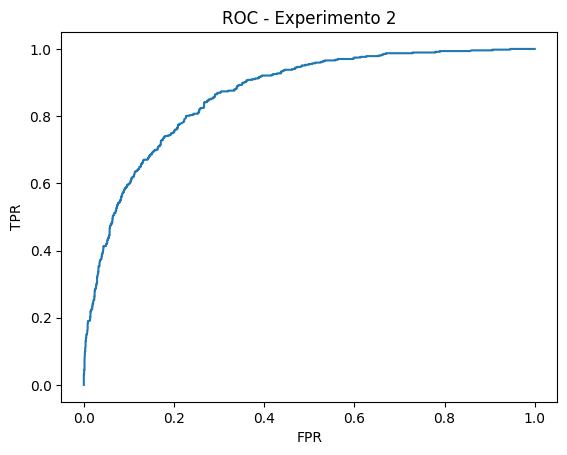

In [72]:


def objective_exp2(trial):
    params = {
        "n_estimators": 300,
        "learning_rate": 0.013,
        "max_depth": 5,
        "min_child_weight": 5,          # exp1
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 20.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 20.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
        "random_state": SEED,
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val, y_proba)


study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_exp2, n_trials=150)   # pode subir pra 100 se quiser

best2 = study2.best_params
print("Melhores parâmetros EXP2:", best2)

model2 = XGBClassifier(**best2,
                       n_estimators=300,
                       learning_rate=0.013,
                       max_depth=5,
                       min_child_weight=5,
                       subsample=0.9,
                       colsample_bytree=0.8,
                       random_state=SEED,
                       eval_metric="logloss"
                      )

model2.fit(X_train, y_train)

# Avaliação final
exp2_results = evaluate_model(model2, X_test, y_test, "Experimento 2")


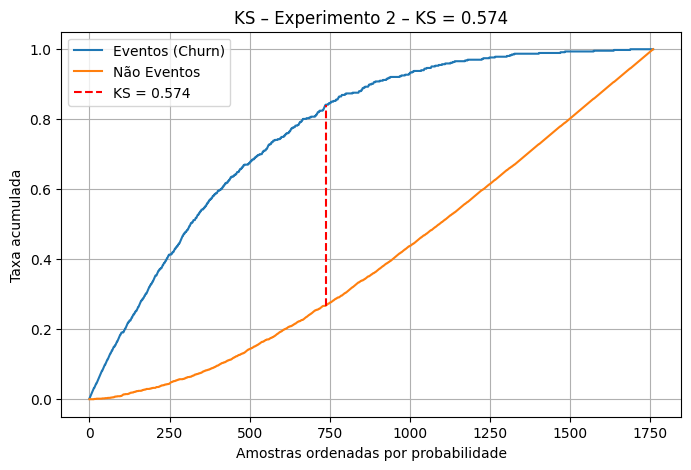

0.5741538115300729

In [73]:
y_prob_exp2 = model2.predict_proba(X_test)[:, 1]
plot_ks_curve(y_test, y_prob_exp2, title="KS – Experimento 2")


In [ ]:
#@title Experimento 3

[I 2025-12-01 03:26:10,836] A new study created in memory with name: no-name-ac5b8ff1-793b-4dbb-a358-41ccbf86d8e2
[I 2025-12-01 03:26:16,864] Trial 0 finished with value: 0.8416274436267868 and parameters: {'n_estimators': 2118, 'learning_rate': 0.055603786736324795, 'max_depth': 6, 'min_child_weight': 5, 'colsample_bytree': 0.8234110695246842, 'subsample': 0.6710393777217883, 'gamma': 6.836961454309524, 'reg_alpha': 9.596380924090523, 'reg_lambda': 2.7623852150810757, 'scale_pos_weight': 4.280842628949351}. Best is trial 0 with value: 0.8416274436267868.
[I 2025-12-01 03:26:18,879] Trial 1 finished with value: 0.8391418722623872 and parameters: {'n_estimators': 927, 'learning_rate': 0.053996012991011484, 'max_depth': 5, 'min_child_weight': 5, 'colsample_bytree': 0.971878081141327, 'subsample': 0.9392684395243593, 'gamma': 7.396434522841155, 'reg_alpha': 3.295129988200254, 'reg_lambda': 1.6610861660690945, 'scale_pos_weight': 7.245270721768867}. Best is trial 0 with value: 0.8416274436

Melhores parâmetros EXP3: {'n_estimators': 2720, 'learning_rate': 0.056059998584394456, 'max_depth': 3, 'min_child_weight': 5, 'colsample_bytree': 0.7004080820288272, 'subsample': 0.6015364336275723, 'gamma': 7.913097983341049, 'reg_alpha': 2.6351227892584914, 'reg_lambda': 13.353527397629144, 'scale_pos_weight': 1.593282100735097}

Experimento 3 
AUC: 0.8703694203853065
KS: 0.584264717076674
MSE: 0.18016760051250458
Cross-Entropy: 0.5318848346191737

Matriz de Confusão:
[[869 425]
 [ 56 411]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1294
           1       0.49      0.88      0.63       467

    accuracy                           0.73      1761
   macro avg       0.72      0.78      0.71      1761
weighted avg       0.82      0.73      0.74      1761



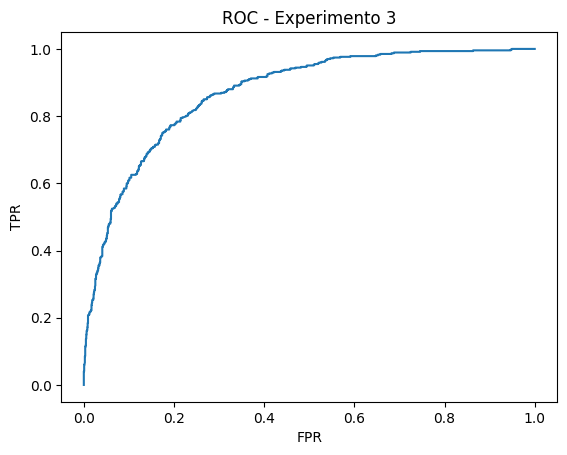

In [76]:


import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

def objective_exp3(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 800, 3500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.06),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),

        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),

        "gamma": trial.suggest_float("gamma", 0.0, 8.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 20.0),

        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 8.0),

        # Fixos
        "random_state": SEED,
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val, y_proba)


# Rodar o estudo
study4 = optuna.create_study(direction="maximize")
study4.optimize(objective_exp3, n_trials=100)


best4 = study4.best_params
print("Melhores parâmetros EXP3:", best4)

# Treinar o modelo final
model4 = XGBClassifier(**best4, random_state=SEED, eval_metric="logloss")
model4.fit(X_train, y_train)

exp4_results = evaluate_model(model4, X_test, y_test, "Experimento 3")


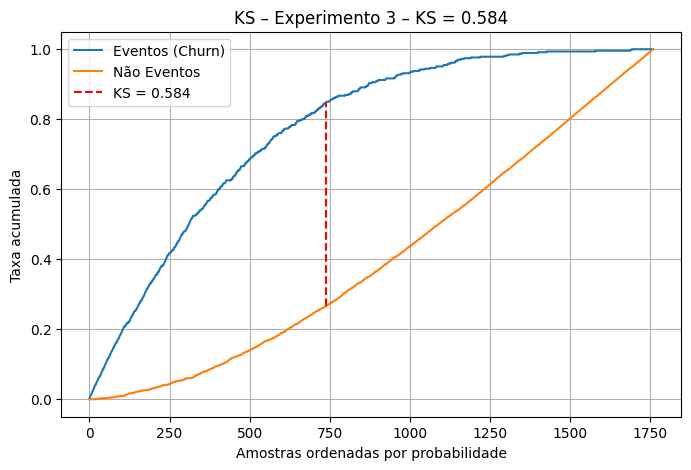

0.584264717076674

In [77]:

y_prob_exp3 = model4.predict_proba(X_test)[:, 1]
plot_ks_curve(y_test, y_prob_exp3, title="KS – Experimento 3")